# Checking whether SDSS has a spectrum for me

## Learning goals

Through this tutorial, you will learn:

 * How to use the "allspec" file either locally or on SciServer to check whether an object you are interested in has SDSS spectra.
 * How to track down the relevant SDSS-V BOSS (optical) parameters and spectrum for galaxies and quasars.
 * How to track down the relevant SDSS-V BOSS (optical) and APOGEE (infrared) parameters and spectrum for stars.

## Introduction

SDSS has observed spectra in several ways over the past 20+ years. Specifically, we have used the SDSS and BOSS optical spectrographs in single-fiber and integral-field modes, and we have used the two APOGEE spectrographs in single-fiber mode. Meanwhile, this data has been processed through a several pipelines and pipeline stages, and is processed into both individual visit and coadded spectra.

To help users track down the relevant information for objects of interest, SDSS has created the `allspec` file. This file lists all spectra that SDSS has created, including all visit spectra and all coadds from every spectrograph. In this file, every object may appear once or more, if they have multiple spectra. 

Objects in SDSS are tracked through the `sdss_id` identifier. This is designed to correspond to unique objects on the sky, and in this notebook we will use it to identify the "same object" across different spectra.

## Imports

We will need several Python modules for our tasks:

 * `os` because we usually need it
 * `matplotlib.pyplot` for plotting
 * `matplotlib` because I'm persnickety about TeXing labels
 * `numpy` because we have to do things with numbers and arrays
 * `astropy.io.fits` to read in the allspec file
 * `fitsio` for efficiently reading very large files (spAll, specObjAll)
 * `astropy.coordinates` for spatial matching
 * `sdss_access` to track down files

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits
import astropy.coordinates
import fitsio
import sdss_access

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 14

## SDSS File Access

`sdss_access` provides ways to track down SDSS files in the data structure. 

This notebook is perhaps easiest to run on SciServer. But if you are working on a machine without a full copy of the SDSS Science Archive Server (SAS), you can set it up to download and cache files locally. See https:://https://sdss-access.readthedocs.io for more information!

In [2]:
sdss_path = sdss_access.path.Path(release='dr19', verbose=True)
access = sdss_access.Access(release='dr19', verbose=True)

## Finding and Reading the `allspec` file

`sdss_path` gives us an easy way to find the path to the `allspec` file.

In [3]:
allspec_file = sdss_path.full('allspec', vers='1.0.1', release='dr19')

if not sdss_path.exists('',full=allspec_file):
    # if the file does not exist locally, this code will download the data.
    access.remote()
    access.add('allspec', vers='1.0.1', release='dr19')
    access.set_stream()
    access.commit()
print(allspec_file)

/Users/jdonor/sas/dr19/spectro/allspec/1.0.1/allspec-dr19-1.0.1.fits.gz


In [4]:
allspec_hdus = astropy.io.fits.open(allspec_file)
allspec = np.array(allspec_hdus[1].data)

## Matching by position to `allspec`

Let's say we have some position of interest. Let's figure out if we have SDSS spectra of any sort near it!

I like the location (ra, dec) = (177.78, -0.73), just because I do. Let's put this in the `astropy.coordinates.SkyCoord` object.

In [5]:
center_ra = [103.40819321]
center_dec = [-1.32137059392]
center_coords = astropy.coordinates.SkyCoord(center_ra, center_dec, unit='deg', frame='icrs')

Each `sdss_id` has a specific RA and Dec, so we only need to match to the unique set of `sdss_id`s. We will put those coordinates into the `astropy` object too.

In [6]:
unique_sdss_id, unique_indx = np.unique(allspec['sdss_id'], return_index=True)
unique_ra = allspec['ra'][unique_indx]
unique_dec = allspec['dec'][unique_indx]

There are a few NaNs as coordinates that need to be removed. This is because the RA and Dec of each row is associated with the spectrum, and sometimes (because the fiber is unplugged or a robot is broken) we don't actually know the RA and Dec of the spectrum. There are only a few of these and it is virtually always the right thing to ignore them.

In [7]:
isfinite = np.isfinite(unique_ra) & np.isfinite(unique_dec)
unique_indx = unique_indx[isfinite]
unique_ra = unique_ra[isfinite]
unique_dec = unique_dec[isfinite]
unique_coords = astropy.coordinates.SkyCoord(unique_ra, unique_dec, unit='deg', frame='icrs')

Now it is easy to match. Let's look at the closest one to our desired position.

In [8]:
indx, sep, s3 = unique_coords.match_to_catalog_sky(center_coords)
sep = sep.value   # avoid units nonsense ("value" is in deg in this case)

In [9]:
iminsep = np.argmin(sep)
match_indx = unique_indx[iminsep]
sdss_id = allspec['sdss_id'][match_indx]

## Information in allspec

Now that we have found a spectrum, we can take a look at the information in `allspec`. Below you can see several types of information:

 * The `allspec` and `multiplex` identifiers (just unique identifiers)
 * Information about the observatory, SDSS phase, and instrument
 * The `sdss_id` and `catalogid` of the target object.
 * Many columns of spectroscopic IDs. Only one set of identifiers will be filled with meaningful information.
 * The name and location of the spectrum file (useful!) and a link to SkyServer

In [10]:
for n in allspec.dtype.names:
    print("{n} :: {v}".format(n=n, v=allspec[n][match_indx]))

allspec_id :: b'sdss5-apo-boss-daily-v6_1_3-103427-59654-27021598031242844-74807581'
multiplex_id :: b'sdss5-apo-boss-v6_1_3-103427-59654'
sdss_phase :: 5
observatory :: b'APO'
instrument :: b'boss'
sdss_id :: 74807581
catalogid :: 27021598031242844
fiberid :: -999
ifudsgn :: -999
plate :: -999
fps_field :: 103427
plate_or_fps_field :: 103427
mjd :: 59654
run2d :: b'v6_1_3'
run1d :: b'v6_1_3'
coadd :: b'daily'
apred_vers :: b''
drpver :: b''
version :: b'v6_1_3'
programname :: b'mwm_yso'
survey :: b'MWM'
sas_file :: b'spec-103427-59654-27021598031242844.fits'
cas_url :: b'https://skyserver.sdss.org/public/VisualTools/explore/summary?sId=7480758101034275965400060103'
sas_url :: b'https://data.sdss.org/sas/dr19/spectro/boss/redux/v6_1_3/spectra/lite/103427/59654/spec-103427-59654-27021598031242844.fits'
ra :: 103.408290969
dec :: -1.32150220553
healpix :: 100755
healpixgrp :: 100
apogee_id :: b''
apogee_field :: b''
telescope :: b''
file_spec :: b'specLite'
apstar_id :: b''
visit_id :: b

## Finding all spectra

We can also find all of the spectra associated with the `sdss_id`. This is useful for objects with repeat spectroscopy.

In [11]:
iallmatch = np.where(allspec['sdss_id'] == allspec['sdss_id'][match_indx])[0]

We can look at what these spectra actually are. It can take some getting used to to figure out this information. What the IDs tell us is:

 * There are three distinct BOSS spectra, which were taken during SDSS-V.
 * We can see that for each MJD (59654 through 59656) there is both a "daily" and an "epoch" coadd. Apparently, the BOSS pipeline considers (for this type of object) that two different days are two different epochs. In this case the "daily" and "epoch" coadds will be very very similar.
 * There are four distinct APOOGEE spectra, and one coadd.

In [12]:
print(allspec['allspec_id'][iallmatch])

[b'sdss5-apo-boss-daily-v6_1_3-103427-59654-27021598031242844-74807581'
 b'sdss5-apo-boss-daily-v6_1_3-103427-59655-27021598031242844-74807581'
 b'sdss5-apo-boss-daily-v6_1_3-103427-59656-27021598031242844-74807581'
 b'sdss5-apo-boss-epoch-v6_1_3-103427-59654-27021598031242844-74807581'
 b'sdss5-apo-boss-epoch-v6_1_3-103427-59655-27021598031242844-74807581'
 b'sdss5-apo-boss-epoch-v6_1_3-103427-59656-27021598031242844-74807581'
 b'sdss5-apo-apogee-1.3-4054-59657-185'
 b'sdss5-apo-apogee-1.3-4003-59654-185'
 b'sdss5-apo-apogee-1.3-4053-59657-144'
 b'sdss5-apo-apogee-1.3-4036-59655-185'
 b'sdss5-apo-apogee-1.3-2M06533798-0119171']


## Looking at the spectra

We can track down the spectra on disk quite easily. The `sas_url` tells us the path. We just need to change the root of the tree to a local file path as follows.

If the data don't already exist on disk (e.g., if you're not running this notebook on SciServer), we can download the data easily with `sdss_access`

In [13]:
url_root = 'https://data.sdss.org/sas'
local_root = os.getenv('SAS_BASE_DIR')
spectrum_files = list()
download_files = list()

for p in allspec["sas_url"][iallmatch]:
    local_path = p.decode().replace(url_root, local_root)
    spectrum_files.append(local_path)
    if not os.path.exists(local_path):
        download_files.append(local_path)

if len(download_files) > 0:
    print("fetching files, please stand by")
    access.remote()
    for local_path in download_files:
        access.add_file(local_path, input_type='filepath')

    access.set_stream()

    # disable follow_symlinks
    access.commit(follow_symlinks=False)

Here then are the paths in the local SAS directory structure:

In [14]:
for f in spectrum_files:
    print(f)

/Users/jdonor/sas/dr19/spectro/boss/redux/v6_1_3/spectra/lite/103427/59654/spec-103427-59654-27021598031242844.fits
/Users/jdonor/sas/dr19/spectro/boss/redux/v6_1_3/spectra/lite/103427/59655/spec-103427-59655-27021598031242844.fits
/Users/jdonor/sas/dr19/spectro/boss/redux/v6_1_3/spectra/lite/103427/59656/spec-103427-59656-27021598031242844.fits
/Users/jdonor/sas/dr19/spectro/boss/redux/v6_1_3/epoch/spectra/lite/103427/59654/spec-103427-59654-27021598031242844.fits
/Users/jdonor/sas/dr19/spectro/boss/redux/v6_1_3/epoch/spectra/lite/103427/59655/spec-103427-59655-27021598031242844.fits
/Users/jdonor/sas/dr19/spectro/boss/redux/v6_1_3/epoch/spectra/lite/103427/59656/spec-103427-59656-27021598031242844.fits
/Users/jdonor/sas/dr19/spectro/apogee/redux/1.3/visit/apo25m/103442/4054/59657/apVisit-1.3-apo25m-4054-59657-185.fits
/Users/jdonor/sas/dr19/spectro/apogee/redux/1.3/visit/apo25m/103442/4003/59654/apVisit-1.3-apo25m-4003-59654-185.fits
/Users/jdonor/sas/dr19/spectro/apogee/redux/1.3/vi

We can open one of the BOSS files up to see what it has in it. We'll first just look at what the HDUs are called.

In [15]:
spec_hdulist = astropy.io.fits.open(spectrum_files[0])

In [16]:
for ihdu, spec_hdu in enumerate(spec_hdulist):
    if('extname' in spec_hdu.header):
        print(spec_hdu.header['extname'])
    else:
        print("HDU{i}".format(i=ihdu))

HDU0
COADD
SPALL
ZALL
ZLINE


It looks like "COADD" actuall has the spectrum. This is a table, and the columns have the fluxes, wavelengths, masks, etc. Really you should look at the data model at: https://data.sdss5.org/datamodel/files/BOSS_SPECTRO_REDUX/RUN2D/spectra/PLATE4/spec.html

In [17]:
coadd = np.array(spec_hdulist['COADD'].data)
coadd_header = spec_hdulist['COADD'].header

In [18]:
print(coadd.dtype.names)

('FLUX', 'LOGLAM', 'IVAR', 'AND_MASK', 'OR_MASK', 'WDISP', 'SKY', 'MODEL', 'WRESL')


But if we want to know the units of FLUX or LOGLAM we can check:

In [19]:
print(coadd_header['TUNIT1'])
print(coadd_header['TUNIT2'])

10^-17 ergs/s/cm^2/Angs
log10(Angs)


Now we can plot and label our plot:

Text(0, 0.5, '$f_\\lambda$ \\rm ($10^{-17}$ erg cm$^{-2}$ s$^{-1}$ \\AA$^{-1}$)')

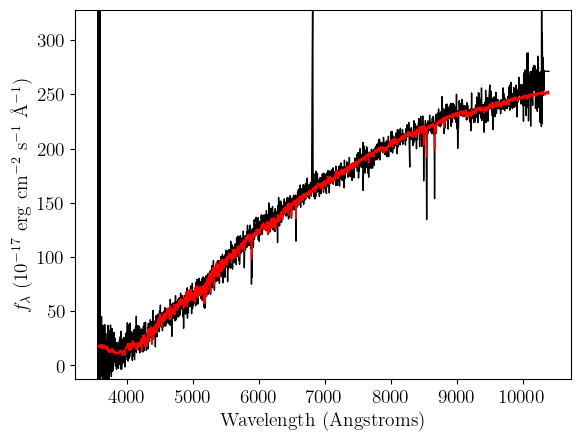

In [20]:
# Let's set sensible limits; the model is better than the data for that
gd = coadd['IVAR'] > 0
gdmax = coadd['MODEL'][gd].max()

plt.plot(10.**coadd['LOGLAM'], coadd['FLUX'], linewidth=1, color='black')
plt.plot(10.**coadd['LOGLAM'], coadd['MODEL'], linewidth=1, color='red')
plt.ylim(np.array([-0.05, 1.3]) * gdmax)

plt.xlabel(r'\rm Wavelength (Angstroms)')
plt.ylabel(r'$f_\lambda$ \rm ($10^{-17}$ erg cm$^{-2}$ s$^{-1}$ \AA$^{-1}$)')

We have three visits so we can compare them.

In [21]:
boss_visits = []
mjds = []
for file in spectrum_files[0:3]:
    spec_hdulist = astropy.io.fits.open(file)
    visit = np.array(spec_hdulist['COADD'].data)
    boss_visits.append(visit)
    mjds.append(spec_hdulist[0].header['MJD'])

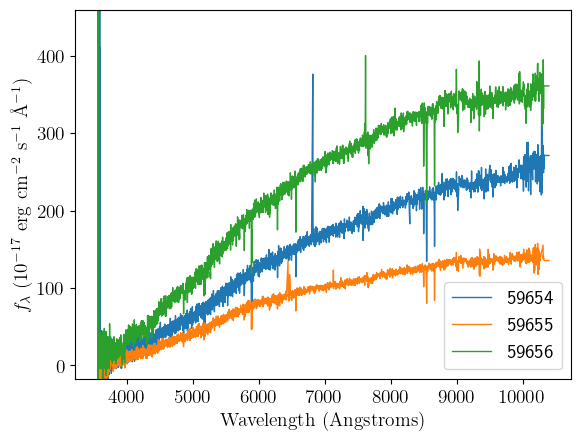

In [22]:
# Let's set sensible limits; the model is better than the data for that
allmax = 0.0
for mjd, visit in zip(mjds, boss_visits):
    gd = visit['IVAR'] > 0
    gdmax = visit['MODEL'][gd].max()
    if(gdmax > allmax):
        allmax = gdmax

    plt.plot(10.**visit['LOGLAM'], visit['FLUX'], linewidth=1, label=str(mjd))

plt.ylim(np.array([-0.05, 1.3]) * allmax)
plt.xlabel(r'\rm Wavelength (Angstroms)')
plt.ylabel(r'$f_\lambda$ \rm ($10^{-17}$ erg cm$^{-2}$ s$^{-1}$ \AA$^{-1}$)')
plt.legend()

This is either exciting or we shouldn't trust the spectrophotometry. In this case, we should not trust the spectrophotometry. This is a deep subject for fiber spectroscopy, but in general you do need to be careful and not leap to conclusions. In this case, these are fairly early SDSS-V observations and likely the fiber positioning is not good enough for good spectrophotometry. In addition, the observing mode we used had fewer spectrophotometric standards (for example, the Reverberation Mapping plates have substantially more)>

We can also look at the APOGEE spectra. Again we can check the HDUs of one of the files in our list associated with an APOGEE visit.

In [23]:
spec_hdulist = astropy.io.fits.open(spectrum_files[6])
for ihdu, spec_hdu in enumerate(spec_hdulist):
    if('extname' in spec_hdu.header):
        print(spec_hdu.header['extname'])
    else:
        print("HDU{i}".format(i=ihdu))

HDU0
FLUX
ERROR
MASK
WAVELENGTH
SKY FLUX
SKY ERROR
TELLURIC
TELLURIC ERROR
WAVE COEFFICIENTS
LSF COEFFICIENTS
HDU11


And we can check the units of the flux.

In [24]:
print(spec_hdulist['FLUX'].header['BUNIT'])

Flux (10^-17 erg/s/cm^2/Ang)


In the case of APOGEE the spectra are a lot harder to interpret by eye! Most of the information is in the fine scale details. You can zoom in and explore with the notebook to try to make sense of it.

Text(0, 0.5, '$f_\\lambda$ \\rm ($10^{-17}$ erg cm$^{-2}$ s$^{-1}$ \\AA$^{-1}$)')

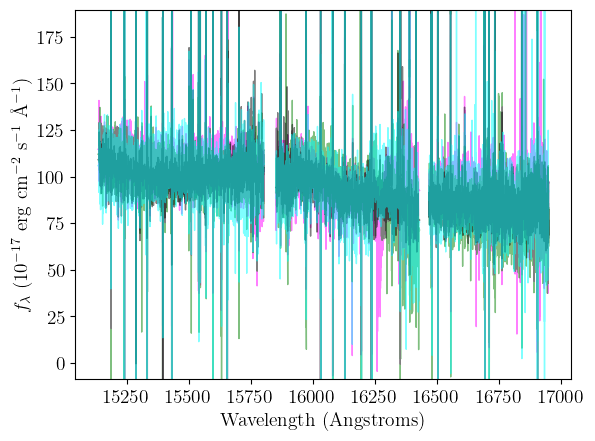

In [25]:
apogee_visits = []
mjds = []
maxmed = 0.
colors = ['magenta', 'green', 'black', 'cyan']
for color, file in zip(colors, spectrum_files[6:10]):
    spec_hdulist = astropy.io.fits.open(file)
    wave = spec_hdulist['WAVELENGTH'].data
    flux = spec_hdulist['FLUX'].data
    med = np.median(flux)
    if(med > maxmed):
        maxmed = med
    for cam in range(0, 3):
        plt.plot(wave[cam, :], flux[cam, :], color=color, linewidth=1, alpha=0.5)

ymax = maxmed * 1.8
plt.ylim(np.array([- 0.05, 1.1]) * ymax)

# Uncomment to zoom in in wavelength
#plt.xlim([16035, 16070])

plt.xlabel(r'\rm Wavelength (Angstroms)')
plt.ylabel(r'$f_\lambda$ \rm ($10^{-17}$ erg cm$^{-2}$ s$^{-1}$ \AA$^{-1}$)')

## Tracking down parameters (BOSS DRP)

Of course, you don't always want to go back to the spectrum! You may often find it easier to just use the catalogs we have. You can do so by matching to our catalogs by `sdss_id`.

For the BOSS DRP, this is useful for looking up general classifications and redshifts, from the `spAll` file. We can again use `sdss_path` to find it, using the `run2d` version associated with DR19.

In [26]:
spall_file = sdss_path.full('spAll', run2d='v6_1_3')

if not sdss_path.exists('',full=spall_file):
    # if the file does not exist locally, this code will download the data.
    access.remote()
    access.add('spAll', run2d='v6_1_3')
    access.set_stream()
    access.commit()
print(spall_file)

/Users/jdonor/sas/dr19/spectro/boss/redux/v6_1_3/spAll-v6_1_3.fits.gz


We don't want to read in all of the columns, it is pretty big. Let's just read in a few important ones.

In [27]:
spall_columns = ['SDSS_ID', 'CARTON_TO_TARGET_PK', 'MJD', 'CLASS', 'SUBCLASS', 'Z', 'ZWARNING']
spall = fitsio.read(spall_file, columns=spall_columns)

Now we can just find the entries associated with the `sdss_id` we have identified.

In [28]:
ispall = np.where(spall['SDSS_ID'] == sdss_id)[0]

We can output the information for each of the three spectra in the file:

In [29]:
for i in ispall:
    print("MJD: {m}, CLASS: {c}, Z : {z}".format(m=spall['MJD'][i], c=spall['CLASS'][i], z=spall['Z'][i]))

MJD: 59654, CLASS: STAR, Z : 0.00025740719866007566
MJD: 59655, CLASS: STAR, Z : 0.00021845850278623402
MJD: 59656, CLASS: STAR, Z : 0.00021172482229303569


If you have a set of more than one `sdss_id`'s you can use `np.intersect1d()` to easily find the entries you need, or convert to `astropy.table.Table` objects and use the `join()` method for those.

## Tracking down parameters (APOGEE DRP)

For the APOGEE DRP, there is a similar summary file. If you are looking at the DRP, you are most likely interested in the individual visits, so the `allVisit` file is what you want. 

In this case you do need to know which telescope the observations are in; if you are looking at many objects, this will involve some logic based on what `allspec` tells you. In our case we will just look. For the APOGEE spectra, it specifies the telescope name (for BOSS it does not, because the data is not organized by telescope).

In [30]:
print(allspec['telescope'][iallmatch])

[b'' b'' b'' b'' b'' b'' b'apo25m' b'apo25m' b'apo25m' b'apo25m' b'apo25m']


Then `sdss_path` tells us where the file is, using the `apred` reduction version associated with DR19:

In [31]:
allvisit_file = sdss_path.full('allVisit', telescope='apo25m', apred='1.3')

if not sdss_path.exists('',full=allvisit_file):
    # if the file does not exist locally, this code will download the data.
    access.remote()
    access.add('allVisit', telescope='apo25m', apred='1.3')
    access.set_stream()
    access.commit()
print(allvisit_file)

/Users/jdonor/sas/dr19/spectro/apogee/redux/1.3/summary/allVisit-1.3-apo25m.fits


Now we can read it in, search by `sdss_id`, and look (for example) at the barycentric radial velocities for each visit. Note that the formal errors reported somewhat underestimate the true errors.

In [32]:
allvisit = fitsio.read(allvisit_file)

In [33]:
iallvisit = np.where(allvisit['sdss_id'] == sdss_id)[0]

In [34]:
for i in iallvisit:
    print("MJD: {m}, vrad: {v:5.3f} +/ {e:5.3} km/s".format(m=allvisit['mjd'][i], v=allvisit['vrad'][i], e=allvisit['vrelerr'][i]))

MJD: 59657, vrad: 72.180 +/ 0.155 km/s
MJD: 59654, vrad: 72.387 +/ 0.166 km/s
MJD: 59657, vrad: 72.787 +/  0.11 km/s
MJD: 59655, vrad: 72.690 +/ 0.201 km/s


## Tracking down parameters (Astra results)

Finally, since this is a star, there will be results in the Astra files. This is a whole other topic, but basically any Astra result file will also have `sdss_id` in it. Note that there are Astra results based on BOSS and on APOGEE, depending on the particular pipeline in the Astra framework being used.

There is a summary file with all processed stars (one row per star). Below we just read it in and show some basic results about the star.

Note that in the "lite" file, the parameters are a best guess based on the pipelines that were run, provided for convenience, but it usually is best to be performing your analysis based on the results of one of the specific pipelines.

See the Astra web documentation for more information: https://sdss.org/dr19/mwm/astra/

In [35]:
mwmlite_file = sdss_path.full('astraMWMLite', v_astra='0.6.0')

if not sdss_path.exists('',full=mwmlite_file):
    # if the file does not exist locally, this code will download the data.
    access.remote()
    access.add('astraMWMLite', v_astra='0.6.0')
    access.set_stream()
    access.commit()
print(mwmlite_file)

mwmlite = fitsio.read(mwmlite_file)

/Users/jdonor/sas/dr19/spectro/astra/0.6.0/summary/astraMWMLite-0.6.0.fits.gz


In [36]:
imwm = np.where(mwmlite['sdss_id'] == sdss_id)[0][0]

In [37]:
print("Teff: {t:5.2f} K, log g: {l:5.2f}, [Fe/H]: {f:5.2f}".format(t=mwmlite['teff'][imwm], l=mwmlite['logg'][imwm], f=mwmlite['fe_h'][imwm]))

Teff: 5665.25 K, log g:  3.79, [Fe/H]: -0.35


## A note on CASJobs

The `allspec` table is also available in CASJobs in the DR19 context, as are the BOSS DRP, APOGEE DRP, and Astra results. So using SQL you can perform many of the same operations using joins with `sdss_id`.

## About this notebook

This notebook was created to illustrate how to use `allspec` in DR19.

Authors: Michael R. Blanton

Last Update: 2025 July 10

If you use astropy for published research, please cite the authors. Follow this link for more information about citing astropy: https://www.astropy.org/acknowledging.html

And of course please cite SDSS when you use our data!
